In [1]:
import pickle
import pandas as pd
import numpy as np
import math

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import boto3
import botocore
import edn_format as edn
import scipy.sparse as sp
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline

# Load in Prime Attribute Mapping

In [2]:
def read_s3_file(bucket_name: str, key: str):
    session = boto3.Session(profile_name='dev')
    s3conn = session.resource('s3')

    a_file = s3conn.Object(bucket_name, key)
    return a_file.get()['Body'].read().decode('UTF-8')

def get_latest_model_params_from_s3(bucket_name: str, s3_key: str):
    try:
        model_params = read_s3_file(bucket_name=bucket_name, key=s3_key)
        return dict(edn.loads(model_params))
    except:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        lines = traceback.format_exception(exc_type, exc_value, exc_traceback)
        print("Unexpected error: {}".format(''.join(lines)))
        return None

class FeatureEncoder:
    """Transforms lists of feature-value mappings to vectors.

    This transformer turns lists of mappings (dict-like objects) of feature
    names to feature values in scipy.sparse matrices.

    Features are expected to be categorical. Feature values will be
    dummy coded (aka 1-of-c encoding).

    Feature values will include independent features as well as conjunctive
    features (feature interactions) of degree 2. An intercept feature will
    also be included.
    """

    def __init__(self, mappings=None):
        if mappings is None:
            self.mappings = {}
        else:
            self.mappings = dict(mappings)

    def _feature_combinations(self, x):
        items = sorted(x.items())
        c1 = list(combinations(items, 1))
        c2 = list(combinations(items, 2))
        return c1 + c2

    def append(self, X):
        for x in X:
            for k in self._feature_combinations(x):
                if k not in self.mappings:
                    self.mappings[k] = len(self.mappings) + 1
        return self

    def transform(self, X):
        indices = []
        indptr = [0]
        for x in X:
            indices.append(0)
            for k in self._feature_combinations(x):
                if k in self.mappings:
                    indices.append(self.mappings[k])
            indptr.append(len(indices))
        shape = (len(indptr) - 1, len(self.mappings) + 1)
        return sp.csr_matrix(([1]*len(indices), indices, indptr),
                             shape=shape, dtype=np.float64)

    def adjust_hyperparams(self, w, H, regularisation=1.0):
        """Given a weight vector `w` and a diagonal Hessian matrix `H`,
        reshape them such that they match the shape of the FeatureEncoder
        by appending zeros to `w` and appending values of `regularisation` to `H`.

        It is assumed that len(self.mappings) >= len(w) + 1.
        """
        diff = len(self.mappings) + 1 - len(w)
        if len(w) != len(H):
            raise ValueError('len(w) must equal len(H)')
        if diff < 0:
            raise ValueError('len(self.mappings) must be >= len(w) + 1')
        w = np.concatenate((w, np.zeros(diff)), axis=0)
        H = np.concatenate((H, np.full(diff, regularisation)), axis=0)
        return w, H

In [3]:
S3_BUCKET_NAME = "roktoptimus"
S3_KEY = "optimus_params/0.3/rokt_optimus_model_params_2017_09_06_07_05_29_UTC.edn"
prior_params = get_latest_model_params_from_s3(bucket_name=S3_BUCKET_NAME, s3_key=S3_KEY)

NameError: name 'sys' is not defined

# Load in Data for non-prime model

In [5]:
_path = "/Users/xuyan/Documents/workspace/optimus/src/training_non_prime_C_2017-09-08 02:22:00.777244+00:00.pkl"

model_training = pickle.load(open(_path, 'rb'))
model_training_pd = pd.DataFrame.from_records(model_training['X'])
# model_training_pd['true_y'] = pd.to_numeric(model_training['y'])
# model_training_pd['pred_y'] = model_training['y_pred']

In [8]:
group_by_columns2 = model_training_pd.columns
group_by_columns = ['agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor']


In [11]:
type(list(group_by_columns2))

list

In [12]:
list(group_by_columns2)

['agegroup',
 'deviceplatform',
 'engagementofferid',
 'gender',
 'publisherwidgetgroupid',
 'publisherwidgetid',
 'repeatvisitor']

In [49]:
group_by_columns = ['agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor']
model_training_groupby_pd = model_training_pd.groupby(group_by_columns).agg({'true_y' : ['mean', 'count']})
model_training_groupby_pd.columns = ["_".join(x) for x in model_training_groupby_pd.columns.ravel()]
model_training_groupby_pd.reset_index(inplace=True)
model_training_groupby_pd = model_training_groupby_pd[model_training_groupby_pd['engagementofferid'] > 0]
model_training_groupby_pd = model_training_groupby_pd.loc[np.repeat(model_training_groupby_pd.index.values,model_training_groupby_pd.true_y_count)]
model_training_groupby_pd = model_training_groupby_pd[model_training_groupby_pd['true_y_count'] >= 10]

In [50]:
model_training_groupby_pd.head(3)

agegroup  deviceplatform    engagementofferid gender  \
65         0               1  2354207961775908156      f   
65         0               1  2354207961775908156      f   
65         0               1  2354207961775908156      f   

    publisherwidgetgroupid  publisherwidgetid  repeatvisitor  true_y_mean  \
65                     766               5917              0     4.429791   
65                     766               5917              0     4.429791   
65                     766               5917              0     4.429791   

    true_y_count  
65           295  
65           295  
65           295

# Rebuild non-prime model

In [51]:
non_prime_rev_model = Ridge(fit_intercept=False, solver='sag')
candidate_alpha = [100.0, 1000.0, 10000.0]
non_prime_rev_grid = GridSearchCV(non_prime_rev_model, {'alpha': candidate_alpha}, iid=False)

feature_coder = FeatureEncoder(prior_params['feature-mappings'])
C_X = feature_coder.transform(model_training_groupby_pd[group_by_columns].to_dict('records'))
C_Y = model_training_groupby_pd['true_y_mean'].values

### normal distribution

In [52]:
non_prime_rev_grid.fit(C_X, C_Y)
C_Y_pred = non_prime_rev_grid.predict(C_X)

print(non_prime_rev_grid.best_estimator_.alpha)
print("mean_absolute_error:", metrics.mean_absolute_error(C_Y, C_Y_pred))
print("r2_score:", metrics.r2_score(C_Y, C_Y_pred))

1000.0
mean_absolute_error: 0.284884369006
r2_score: 0.626206890687


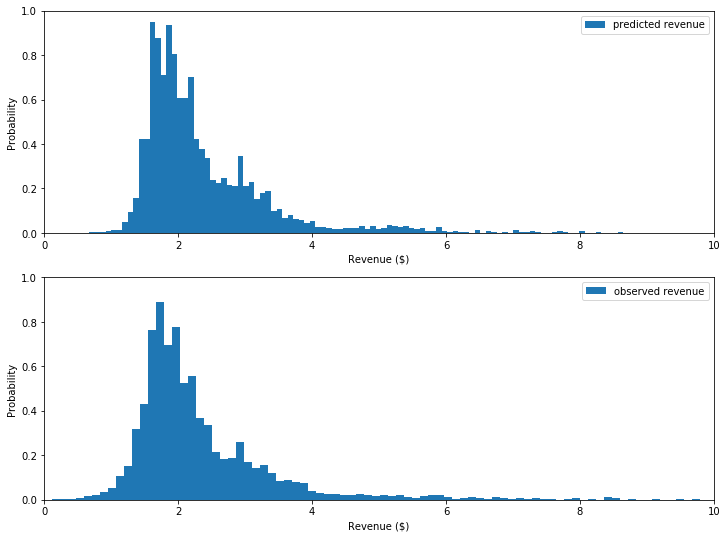

In [65]:
plt.figure(figsize = (12,9))

plt.subplot(211)
plt.hist(C_Y_pred, bins=100, normed=True, label="predicted revenue")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Probability")

plt.subplot(212)
plt.hist(C_Y, bins=1000, normed=True, label="observed revenue")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Probability")

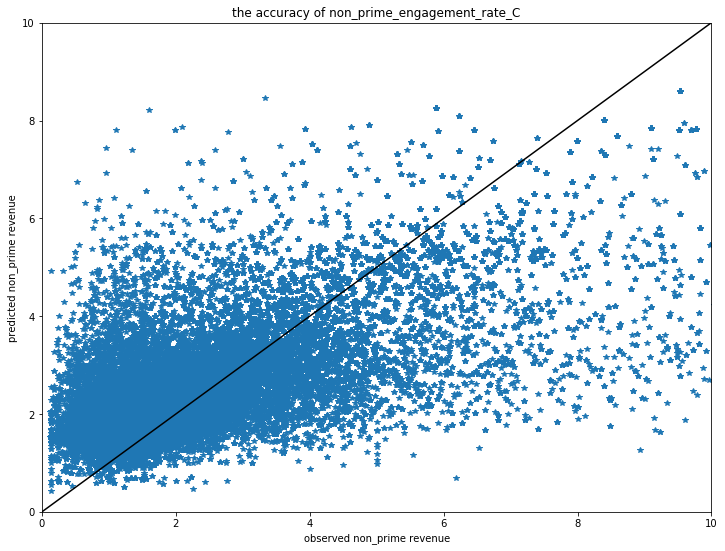

In [54]:
plt.figure(figsize = (12,9))
plt.plot(C_Y, C_Y_pred, '*')
plt.plot([0, 10], [0, 10], 'k-')
plt.axis([0, 10, 0, 10])
plt.xlabel("observed non_prime revenue")
plt.ylabel("predicted non_prime revenue")
plt.title("the accuracy of non_prime_engagement_rate_C")

### lognormal distribution

In [55]:
C_log_Y = np.log(C_Y)
non_prime_rev_grid2 = GridSearchCV(non_prime_rev_model, {'alpha': candidate_alpha}, iid=False)
non_prime_rev_grid2.fit(C_X, C_log_Y)
C_log_Y_pred = non_prime_rev_grid2.predict(C_X)
print("mean_absolute_error:", metrics.mean_absolute_error(C_Y, np.exp(C_log_Y_pred)))
print("r2_score:", metrics.r2_score(C_Y, np.exp(C_log_Y_pred)))

mean_absolute_error: 0.271708958157
r2_score: 0.593823479873


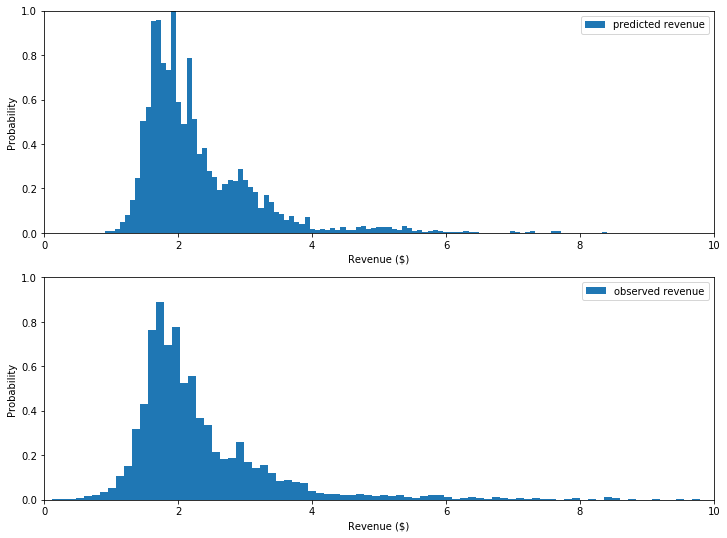

In [63]:
plt.figure(figsize = (12,9))

plt.subplot(211)
plt.hist(np.exp(C_log_Y_pred), bins=100, normed=True, label="predicted revenue")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Probability")

plt.subplot(212)
plt.hist(C_Y, bins=1000, normed=True, label="observed revenue")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Probability")

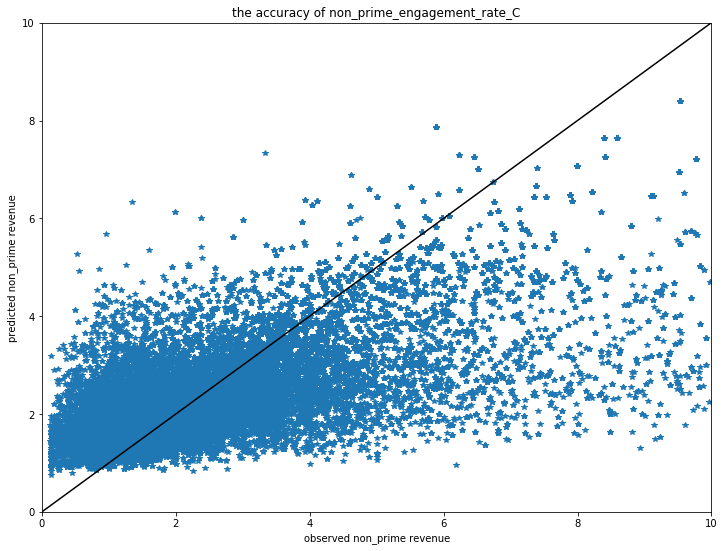

In [60]:
plt.figure(figsize = (12,9))
plt.plot(C_Y, np.exp(C_log_Y_pred), '*')
plt.plot([0, 10], [0, 10], 'k-')
plt.axis([0, 10, 0, 10])
plt.xlabel("observed non_prime revenue")
plt.ylabel("predicted non_prime revenue")
plt.title("the accuracy of non_prime_engagement_rate_C")